# 基于PaddlePaddle2.0的蝴蝶图像识别分类——利用预训练残差网络ResNet101模型

作者：陆平老师

## 1. 蝴蝶识别分类任务概述

人工智能技术的应用领域日趋广泛，新的智能应用层出不穷。本项目将利用人工智能技术来对蝴蝶图像进行分类，需要能对蝴蝶的类别、属性进行细粒度的识别分类。相关研究工作者能够根据采集到的蝴蝶图片，快速识别图中蝴蝶的种类。期望能够有助于提升蝴蝶识别工作的效率和精度。

## 2. 创建项目和挂载数据

数据集都来源于网络公开数据（和鲸社区）。图片中所涉及的蝴蝶总共有9个属，20个物种，文件genus.txt中描述了9个属名，species.txt描述了20个物种名。

在创建项目时，可以为该项目挂载Butterfly20蝴蝶数据集，即便项目重启，该挂载的数据集也不会被自动清除。具体方法如下：首先采用notebook方式构建项目，项目创建框中的最下方有个数据集选项，选择“+添加数据集”。然后，弹出搜索框，在关键词栏目输入“bufferfly20”，便能够查询到该数据集。最后，选中该数据集，可以自动在项目中挂载该数据集了。

需要注意的是，每次重新打开该项目，data文件夹下除了挂载的数据集，其他文件都将被删除。

被挂载的数据集会自动出现在data目录之下，通常是压缩包的形式。在data/data63004目录，其中有两个压缩文件，分别是Butterfly20.zip和Butterfly20_test.zip。也可以利用下载功能把数据集下载到本地进行训练。

## 3. 初探蝴蝶数据集

我们看看蝴蝶图像数据长什么样子？

首先，解压缩数据。类以下几个步骤：

第一步，把当前路径转换到data目录，可以使用命令!cd data。在AI studio nootbook中可以使用Linux命令，需要在命令的最前面加上英文的感叹号(!)。用&&可以连接两个命令。用\号可以换行写代码。需要注意的是，每次重新打开该项目，data文件夹下除了挂载的数据集，其他文件都会被清空。因此，如果把数据保存在data目录中，每次重新启动项目时，都需要解压缩一下。如果想省事持久化保存，可以把数据保存在work目录下。

实际上，!加某命令的模式，等价于python中的get_ipython().system('某命令')模式。

第二步，利用unzip命令，把压缩包解压到当前路径。unzip的-q参数代表执行时不显示任何信息。unzip的-o参数代表不必先询问用户，unzip执行后覆盖原有的文件。两个参数合起来，可以写为-qo。

第三步，用rm命令可以把一些文件夹给删掉，比如，__MACOSX文件夹

In [1]:
!cd data &&\
unzip -qo data63004/Butterfly20_test.zip &&\
unzip -qo data63004/Butterfly20.zip &&\
rm -r __MACOSX

接着，我们分析一下数据集，发现Butterfly20文件夹中有很多子文件夹，每个子文件夹下又有很多图片，每个子文件夹的名字都是蝴蝶属种的名字。由此，可以推测每个文件夹下是样本，而样本的标签就是子文件夹的名字。

我们绘制data/Butterfly20/001.Atrophaneura_horishanus文件夹下的图片006.jpg。根据百度百科，Atrophaneura horishanus是凤蝶科、曙凤蝶属的一个物种。

我们再绘制data/Butterfly20/002.Atrophaneura_varuna文件夹下的图片006.jpg。根据百度百科，Atrophaneura varuna对应的中文名称是“瓦曙凤蝶”，它是凤蝶科、曙凤蝶属的另一个物种。

虽然乍一看蝴蝶都是相似的，但不同属种的蝴蝶在形状、颜色等细节方面还是存在很大的差别。

In [2]:
import matplotlib.pyplot as plt
import PIL.Image as Image

path='/home/aistudio/data/Butterfly20/001.Atrophaneura_horishanus/006.jpg'
img = Image.open(path)
plt.imshow(img)          #根据数组绘制图像
plt.show()               #显示图像

<Figure size 640x480 with 1 Axes>

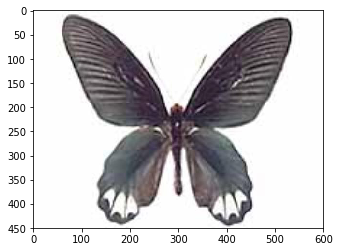

In [3]:
path='/home/aistudio/data/Butterfly20/002.Atrophaneura_varuna/006.jpg'
img = Image.open(path)
plt.imshow(img)          #根据数组绘制图像
plt.show()               #显示图像

更具挑战的是，即便属于同一属种，不同的蝴蝶图片在角度、明暗、背景、姿态、颜色等方面均存在不小差别。甚至有的图片里面有多只蝴蝶。以下两张蝴蝶图片均出自同一个属种Atrophaneura horishanus。

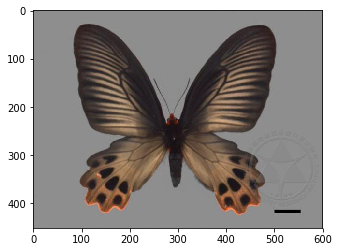

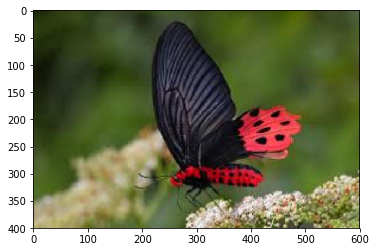

In [4]:
path1='/home/aistudio/data/Butterfly20/001.Atrophaneura_horishanus/006.jpg'
path2='/home/aistudio/data/Butterfly20/001.Atrophaneura_horishanus/150.jpg'

img1 = Image.open(path1)
plt.imshow(img1)          #根据数组绘制图像
plt.show()

img2 = Image.open(path2)
plt.imshow(img2)          #根据数组绘制图像
plt.show()               #显示图像

## 4. 准备数据

数据准备过程包括以下两个重点步骤：

一是建立样本数据读取路径与样本标签之间的关系。

二是构造读取器与数据预处理。可以写个自定义数据读取器，它继承于PaddlePaddle2.0的dataset类，在__getitem__方法中把自定义的预处理方法加载进去。

In [5]:
#以下代码用于建立样本数据读取路径与样本标签之间的关系
import os
import random

data_list = [] #用个列表保存每个样本的读取路径、标签

#由于属种名称本身是字符串，而输入模型的是数字。需要构造一个字典，把某个数字代表该属种名称。键是属种名称，值是整数。
label_list=[]
with open("/home/aistudio/data/species.txt") as f:
    for line in f:
        a,b = line.strip("\n").split(" ")
        label_list.append([b, int(a)-1])
label_dic = dict(label_list)

#获取Butterfly20目录下的所有子目录名称，保存进一个列表之中
class_list = os.listdir("/home/aistudio/data/Butterfly20")
class_list.remove('.DS_Store') #删掉列表中名为.DS_Store的元素，因为.DS_Store并没有样本。

for each in class_list:
    for f in os.listdir("/home/aistudio/data/Butterfly20/"+each):
        data_list.append(["/home/aistudio/data/Butterfly20/"+each+'/'+f,label_dic[each]])

#按文件顺序读取，可能造成很多属种图片存在序列相关，用random.shuffle方法把样本顺序彻底打乱。
random.shuffle(data_list)

#打印前十个，可以看出data_list列表中的每个元素是[样本读取路径, 样本标签]。
print(data_list[0:10])

#打印样本数量，一共有1866个样本。
print("样本数量是：{}".format(len(data_list)))

[['/home/aistudio/data/Butterfly20/020.Papilio_hermosanus/097.jpg', 19], ['/home/aistudio/data/Butterfly20/019.Papilio_dialis/061.jpg', 18], ['/home/aistudio/data/Butterfly20/018.Papilio_bianor/026.jpg', 17], ['/home/aistudio/data/Butterfly20/001.Atrophaneura_horishanus/088.jpg', 0], ['/home/aistudio/data/Butterfly20/005.Byasa_polyeuctes/159.jpg', 4], ['/home/aistudio/data/Butterfly20/012.Losaria_coon/052.jpg', 11], ['/home/aistudio/data/Butterfly20/002.Atrophaneura_varuna/031.jpg', 1], ['/home/aistudio/data/Butterfly20/001.Atrophaneura_horishanus/060.jpg', 0], ['/home/aistudio/data/Butterfly20/011.Lamproptera_meges/014.jpg', 10], ['/home/aistudio/data/Butterfly20/007.Graphium_cloanthus/017.jpg', 6]]
样本数量是：1866


In [6]:
#以下代码用于构造读取器与数据预处理
#首先需要导入相关的模块
import paddle
from paddle.vision.transforms import Compose, ColorJitter, Resize,Transpose, Normalize,BrightnessTransform,RandomVerticalFlip,RandomHorizontalFlip,RandomRotation
import cv2
import numpy as np
from PIL import Image
from paddle.io import Dataset

#自定义的数据预处理函数，输入原始图像，输出处理后的图像，可以借用paddle.vision.transforms的数据处理功能
def preprocess(img):
    transform = Compose([
        Resize(size=(224, 224)), #把数据长宽像素调成224*224
        #ColorJitter(0.4, 0.4, 0.4, 0.4),# 随机调整图像的亮度，对比度，饱和度和色调。
        #RandomHorizontalFlip(224),
        #RandomVerticalFlip(224),
        BrightnessTransform(0.2),
        
        Normalize(mean=[127.5, 127.5, 127.5], std=[127.5, 127.5, 127.5], data_format='HWC'), #标准化
        Transpose(), #原始数据形状维度是HWC格式，经过Transpose，转换为CHW格式
        ])
    img = transform(img).astype("float32")
    return img

#自定义数据读取器
class Reader(Dataset):
    def __init__(self, data, is_val=False):
        super().__init__()
        #在初始化阶段，把数据集划分训练集和测试集。由于在读取前样本已经被打乱顺序，取20%的样本作为测试集，80%的样本作为训练集。
        self.samples = data[-int(len(data)*0.2):] if is_val else data[:-int(len(data)*0.2)]

    def __getitem__(self, idx):
        #处理图像
        img_path = self.samples[idx][0] #得到某样本的路径
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = preprocess(img) #数据预处理--这里仅包括简单数据预处理，没有用到数据增强

        #处理标签
        label = self.samples[idx][1] #得到某样本的标签
        label = np.array([label], dtype="int64") #把标签数据类型转成int64
        return img, label

    def __len__(self):
        #返回每个Epoch中图片数量
        return len(self.samples)

#生成训练数据集实例
train_dataset = Reader(data_list, is_val=False)

#生成测试数据集实例
eval_dataset = Reader(data_list, is_val=True)

#打印一个训练样本
#print(train_dataset[1136][0])
print(train_dataset[1136][0].shape)
print(train_dataset[1136][1])


(3, 224, 224)
[4]


## 5. 建立模型

为了提升探索速度，建议首先选用比较成熟的基础模型，看看基础模型所能够达到的准确度。之后再试试模型融合，准确度是否有提升。最后可以试试自己独创模型。

为简便，这里直接采用101层的残差网络ResNet，并且采用预训练模式。为什么要采用预训练模型呢？因为通常模型参数采用随机初始化，而预训练模型参数初始值是一个比较确定的值。这个参数初始值是经历了大量任务训练而得来的，比如用CIFAR图像识别任务来训练模型，得到的参数。虽然蝴蝶识别任务和CIFAR图像识别任务是不同的，但可能存在某些机器视觉上的共性。用预训练模型可能能够较快地得到比较好的准确度。

在PaddlePaddle2.0中，使用预训练模型只需要设定模型参数pretained=True。值得注意的是，预训练模型得出的结果类别是1000维度，要用个线性变换，把类别转化为20维度。

In [7]:
#定义模型
class MyNet(paddle.nn.Layer):
    def __init__(self):
        super(MyNet,self).__init__()
        self.layer=paddle.vision.models.resnet101(pretrained=True)
        self.fc = paddle.nn.Linear(1000, 20)
    #网络的前向计算过程
    def forward(self,x):
        x=self.layer(x)
        x=self.fc(x)
        return x

## 6. 应用高阶API训练模型

一是定义输入数据形状大小和数据类型。

二是实例化模型。如果要用高阶API，需要用Paddle.Model()对模型进行封装，如model = paddle.Model(model,inputs=input_define,labels=label_define)。

三是定义优化器。这个使用Adam优化器，学习率设置为0.0001，优化器中的学习率(learning_rate)参数很重要。要是训练过程中得到的准确率呈震荡状态，忽大忽小，可以试试进一步把学习率调低。

四是准备模型。这里用到高阶API，model.prepare()。

五是训练模型。这里用到高阶API，model.fit()。参数意义详见下述代码注释。

In [8]:
#定义输入
input_define = paddle.static.InputSpec(shape=[-1,3,224,224], dtype="float32", name="img")
label_define = paddle.static.InputSpec(shape=[-1,1], dtype="int64", name="label")

#实例化网络对象并定义优化器等训练逻辑
model = MyNet()
model = paddle.Model(model,inputs=input_define,labels=label_define) #用Paddle.Model()对模型进行封装
optimizer = paddle.optimizer.Adam(learning_rate=0.0001, parameters=model.parameters(),
                                    #weight_decay=0.1 # 正则化
                                                    )
#上述优化器中的学习率(learning_rate)参数很重要。要是训练过程中得到的准确率呈震荡状态，忽大忽小，可以试试进一步把学习率调低。

model.prepare(optimizer=optimizer, #指定优化器
              loss=paddle.nn.CrossEntropyLoss(), #指定损失函数
              metrics=paddle.metric.Accuracy()) #指定评估方法

# 训练可视化VisualDL工具的回调函数
visualdl = paddle.callbacks.VisualDL(log_dir='visualdl_log')

model.fit(train_data=train_dataset,     #训练数据集
          eval_data=eval_dataset,         #测试数据集
          batch_size=64,                  #一个批次的样本数量
          epochs=40,                      #迭代轮次
          save_dir="/home/aistudio/lup", #把模型参数、优化器参数保存至自定义的文件夹
          save_freq=20,                    #设定每隔多少个epoch保存模型参数及优化器参数
          log_freq=100,                     #打印日志的频率
          callbacks=[visualdl]              #可视化
)

2021-03-26 19:33:34,796 - INFO - unique_endpoints {''}
2021-03-26 19:33:34,798 - INFO - Downloading resnet101.pdparams from https://paddle-hapi.bj.bcebos.com/models/resnet101.pdparams
100%|██████████| 263160/263160 [00:03<00:00, 72150.72it/s]
2021-03-26 19:33:38,561 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams md5 checking...


The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/40


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


step 24/24 - loss: 0.4608 - acc: 0.5305 - 578ms/step
save checkpoint at /home/aistudio/lup/0
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 6/6 - loss: 0.4605 - acc: 0.8043 - 508ms/step
Eval samples: 373
Epoch 2/40
step 24/24 - loss: 0.5013 - acc: 0.9411 - 568ms/step
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 6/6 - loss: 0.2203 - acc: 0.8338 - 506ms/step
Eval samples: 373
Epoch 3/40
step 24/24 - loss: 0.0475 - acc: 0.9879 - 571ms/step
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 6/6 - loss: 0.2209 - acc: 0.8418 - 502ms/step
Eval samples: 373
Epoch 4/40
step 24/24 - loss: 0.0035 - acc: 0.9967 - 573ms/step
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 6/6 - l

In [9]:
result = model.evaluate(eval_dataset, verbose=1)

print(result)

Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 373/373 [==============================] - loss: 5.3666e-04 - acc: 0.8820 - 54ms/step    
Eval samples: 373
{'loss': [0.0005366554], 'acc': 0.8820375335120644}


## 7. 应用已经训练好的模型进行预测

如果是要参加建模比赛，通常赛事组织方会提供待预测的数据集，我们需要利用自己构建的模型，来对待预测数据集合中的数据标签进行预测。也就是说，我们其实并不知道到其真实标签是什么，只有比赛的组织方知道真实标签，我们的模型预测结果越接近真实结果，那么分数也就越高。

预测流程分为以下几个步骤：

一是构建数据读取器。因为预测数据集没有标签，该读取器写法和训练数据读取器不一样，建议重新写一个类，继承于Dataset基类。

二是实例化模型。如果要用高阶API，需要用Paddle.Model()对模型进行封装，如paddle.Model(MyNet(),inputs=input_define)，由于是预测模型，所以仅设定输入数据格式就好了。

三是读取刚刚训练好的参数。这个保存在/home/aistudio/work目录之下，如果指定的是final则是最后一轮训练后的结果。可以指定其他轮次的结果，比如model.load('/home/aistudio/work/30')，这里用到了高阶API，model.load()

四是准备模型。这里用到高阶API，model.prepare()。

五是读取待预测集合中的数据，利用已经训练好的模型进行预测。

六是结果保存。

In [10]:
class InferDataset(Dataset):
    def __init__(self, img_path=None):
        """
        数据读取Reader(推理)
        :param img_path: 推理单张图片
        """
        super().__init__()
        if img_path:
            self.img_paths = [img_path]
        else:
            raise Exception("请指定需要预测对应图片路径")

    def __getitem__(self, index):
        # 获取图像路径
        img_path = self.img_paths[index]
        # 使用Pillow来读取图像数据并转成Numpy格式
        img = Image.open(img_path)
        if img.mode != 'RGB': 
            img = img.convert('RGB') 
        img = preprocess(img) #数据预处理--这里仅包括简单数据预处理，没有用到数据增强
        return img

    def __len__(self):
        return len(self.img_paths)

#实例化推理模型
model = paddle.Model(MyNet(),inputs=input_define)

#读取刚刚训练好的参数
model.load('/home/aistudio/lup/final')

#准备模型
model.prepare()

#得到待预测数据集中每个图像的读取路径
infer_list=[]
with open("/home/aistudio/data/testpath.txt") as file_pred:
    for line in file_pred:
        infer_list.append("/home/aistudio/data/"+line.strip())

#模型预测结果通常是个数，需要获得其对应的文字标签。这里需要建立一个字典。
def get_label_dict2():
    label_list2=[]
    with open("/home/aistudio/data/species.txt") as filess:
        for line in filess:
            a,b = line.strip("\n").split(" ")
            label_list2.append([int(a)-1, b])
    label_dic2 = dict(label_list2)
    return label_dic2

label_dict2 = get_label_dict2()
#print(label_dict2)

#利用训练好的模型进行预测
results=[]
for infer_path in infer_list:
    infer_data = InferDataset(infer_path)
    result = model.predict(test_data=infer_data)[0] #关键代码，实现预测功能
    result = paddle.to_tensor(result)
    result = np.argmax(result.numpy()) #获得最大值所在的序号
    results.append("{}".format(label_dict2[result])) #查找该序号所对应的标签名字

#把结果保存起来
with open("work/result.txt", "w") as f:
    for r in results:
        f.write("{}\n".format(r))

2021-03-26 19:55:49,918 - INFO - unique_endpoints {''}
[INFO 2021-03-26 19:55:49,918 download.py:154] unique_endpoints {''}
2021-03-26 19:55:49,919 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams md5 checking...
[INFO 2021-03-26 19:55:49,919 download.py:251] File /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams md5 checking...
2021-03-26 19:55:50,516 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams
[INFO 2021-03-26 19:55:50,516 download.py:184] Found /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams


Predict begin...
step 1/1 [==============================] - 68ms/step
Predict samples: 1
Predict begin...
step 1/1 [==============================] - 59ms/step
Predict samples: 1
Predict begin...
step 1/1 [==============================] - 61ms/step
Predict samples: 1
Predict begin...
step 1/1 [==============================] - 59ms/step
Predict samples: 1
Predict begin...
step 1/1 [==============================] - 58ms/step
Predict samples: 1
Predict begin...
step 1/1 [==============================] - 60ms/step
Predict samples: 1
Predict begin...
step 1/1 [==============================] - 60ms/step
Predict samples: 1
Predict begin...
step 1/1 [==============================] - 61ms/step
Predict samples: 1
Predict begin...
step 1/1 [==============================] - 59ms/step
Predict samples: 1
Predict begin...
step 1/1 [==============================] - 60ms/step
Predict samples: 1
Predict begin...
step 1/1 [==============================] - 60ms/step
Predict samples: 1
Predict be

该模型在测试集上的准确度约为85%左右。接下来，便可以探索使用数据增强、自定义模型等方式，看看能否取得更好的结果。